# OpenET SSEBop
## Image Class Property/Method Example
This example shows how to instantiate the model Image class for a single Landsat image using the ".from_landsat_c2_sr()" helper method.  This example also shows how to get the model variables such as tcorr.

## Setup

### Install Earth Engine

In [1]:
# Import the Earth Engine package, installing it first, if needed.
try:
    import ee
except ModuleNotFoundError:
    !pip install earthengine-api
    import ee

### Install SSEBop

In [2]:
# Import the SSEBop package, installing it first, if needed.
try:
    import openet.ssebop as model
except ModuleNotFoundError:
    !pip install openet-ssebop
    import openet.ssebop as model

### Package Imports

In [3]:
import pprint

from IPython.display import Image

### Initialize Earth Engine

In [4]:
# Initialize the Earth Engine package, initiating the authentication flow if needed.
try:
    ee.Initialize()
except ee.EEException:
    ee.Authenticate()
    ee.Initialize()

## Analysis

In [5]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
viridis_palette = ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']

image_size = 768

### Landsat 8 Collection 2 SR Image

In [6]:
landsat_img = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_037030_20220830')

clip_geom = ee.Geometry.Point(-109.9804, 42.8045).buffer(60000).bounds(1, 'EPSG:32612')
clip_region = clip_geom.getInfo()
# clip_geom = ee.Geometry.Rectangle([550000, 4250000, 640000, 4300000], 'EPSG:32612', False)
# clip_region = clip_geom.bounds(1, 'EPSG:32612').getInfo()

landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']
landsat_dt = ee.Date(landsat_img.get('system:time_start'))
# print(landsat_img.get('system:time_start').getInfo())

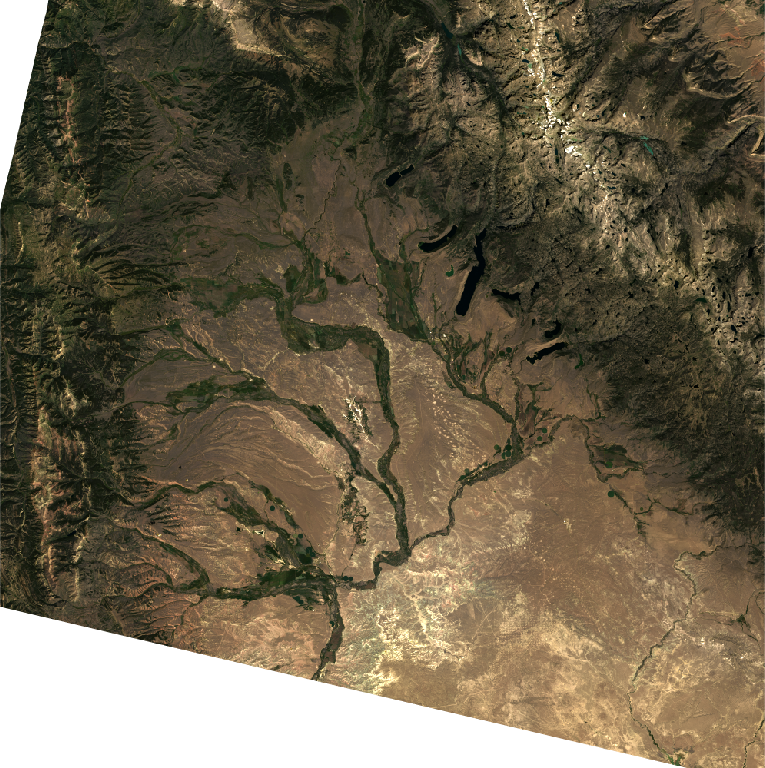

In [7]:
image_url = landsat_img.select(['SR_B4', 'SR_B3', 'SR_B2']).clip(clip_geom)\
    .multiply([0.0000275, 0.0000275, 0.0000275])\
    .add([-0.2, -0.2, -0.2])\
    .getThumbURL({'min': 0.0, 'max': 0.3, 'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [8]:
model_obj = model.Image.from_landsat_c2_sr(
    landsat_img, 
    tcorr_source='FANO',
    et_reference_source='projects/openet/reference_et/gridmet/daily', 
    et_reference_band='eto', 
    et_reference_factor=1.0,
    et_reference_resample='nearest',
    # et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    # et_reference_band='eto', 
    # et_reference_factor=0.85,
    # et_reference_resample='nearest',
)

### NDVI

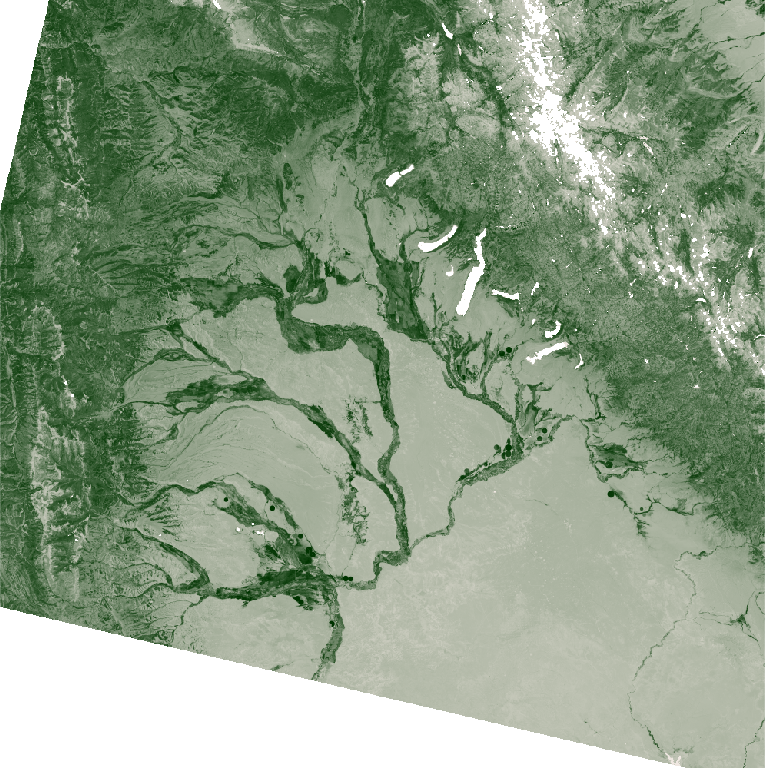

In [9]:
image_url = model_obj.ndvi.clip(clip_geom)\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Gridded Tcorr

In [10]:
# pprint.pprint(model_obj.tcorr.getInfo())

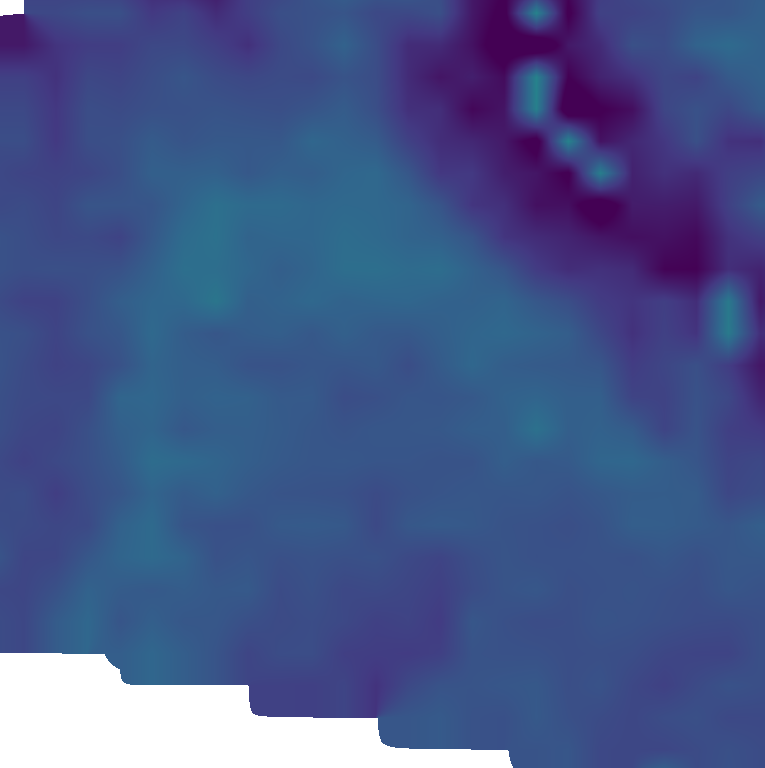

In [19]:
image_url = model_obj.tcorr.reproject(crs=landsat_crs, scale=30).updateMask(1)\
    .getThumbURL({'min': 0.97, 'max': 1.1, 'palette': viridis_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Tcorr "Quality"

In [12]:
# image_url = ee.Image(model_obj.tcorr).select(['quality'])\
#     .getThumbURL({'min': 0, 'max': 20, 'palette': viridis_palette, 
#                   'region': clip_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

### ET fraction

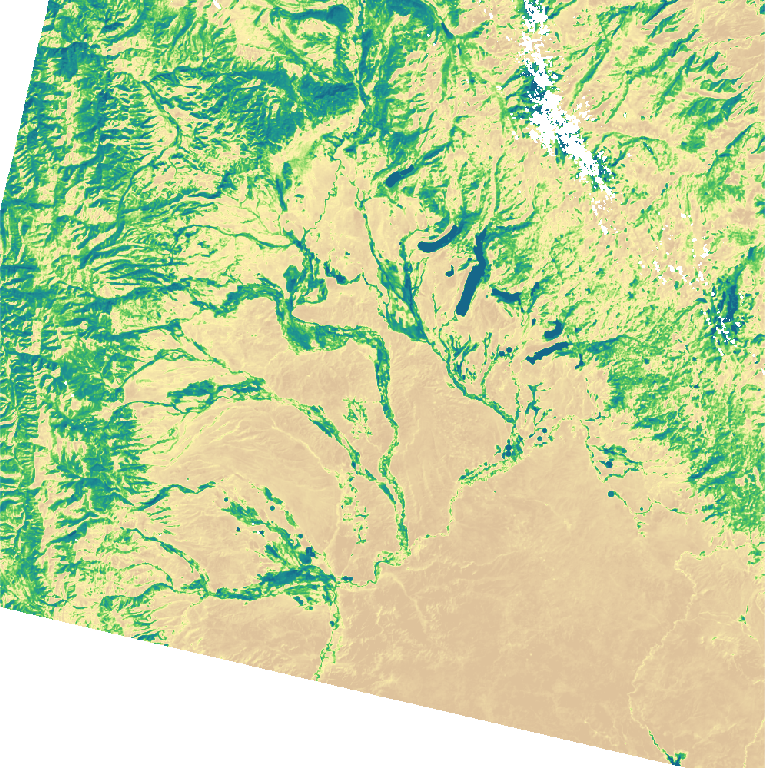

In [13]:
image_url = model_obj.et_fraction.clip(clip_geom)\
    .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### Reference ET

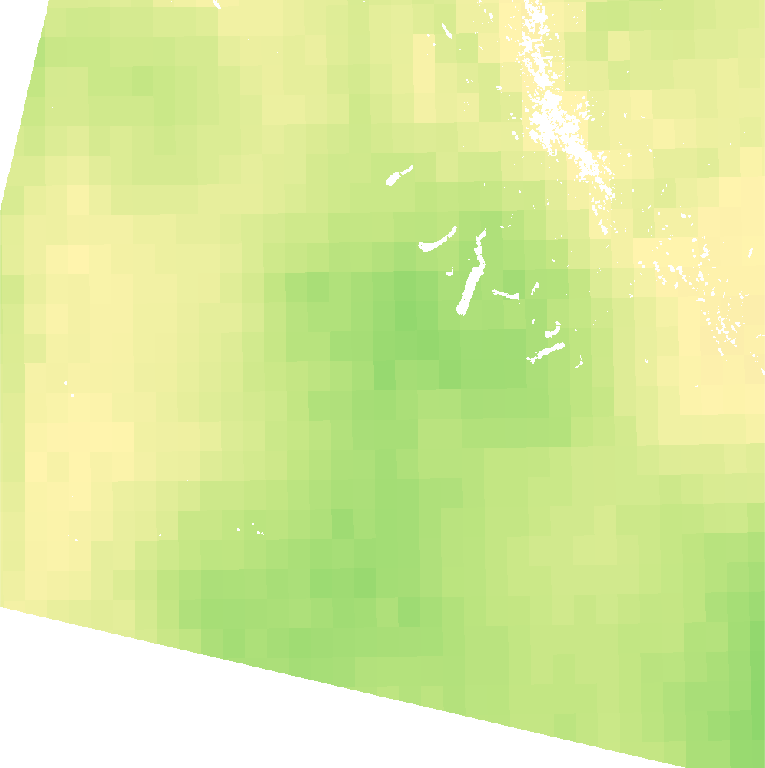

In [14]:
# Clip and project to the Landsat image footprint and coordinate system
image_url = model_obj.et_reference.clip(clip_geom)\
    .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### ET

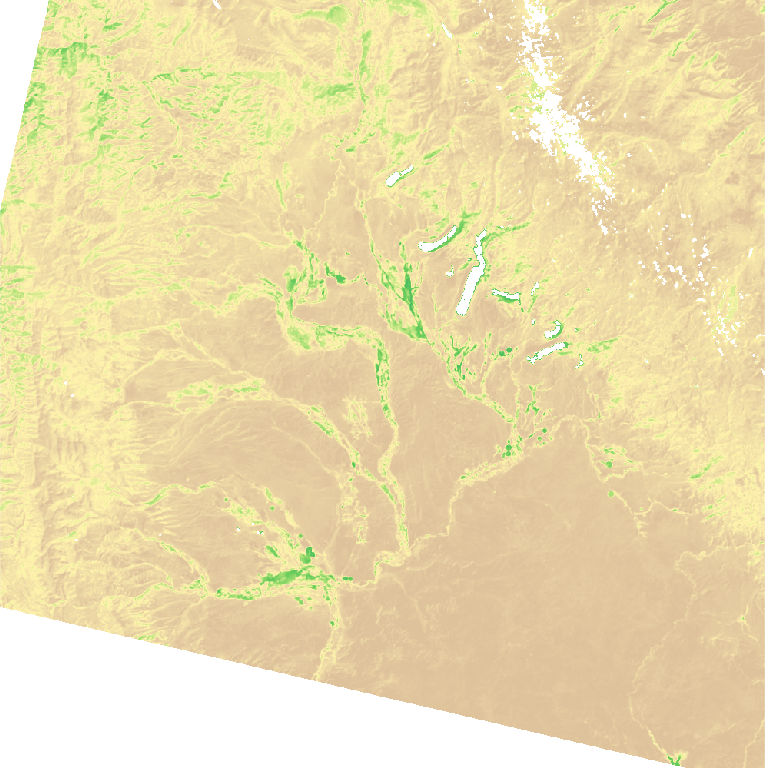

In [15]:
image_url = model_obj.et.clip(clip_geom)\
    .getThumbURL({'min': 0.0, 'max': 10, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

### "Calculate" Method

Return a multiband image of the model variables

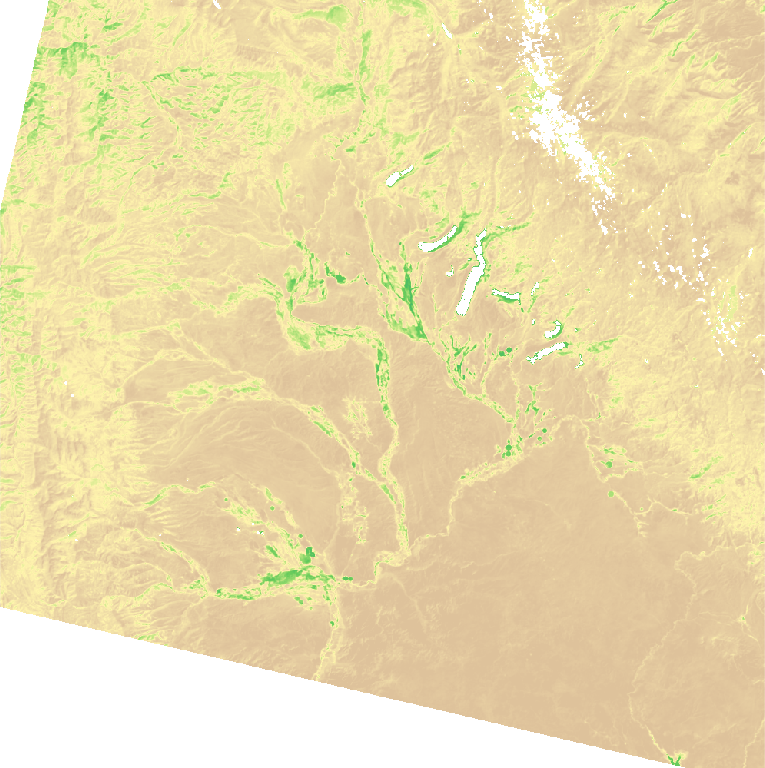

In [16]:
image_url = model_obj.calculate(['et', 'et_reference', 'et_fraction']).select(['et']).clip(clip_geom)\
    .getThumbURL({'min': 0.0, 'max': 10, 'palette': et_palette, 
                  'region': clip_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')